# Анализ тарифов оператора сотовой связи

## Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.  

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов

**Тариф «Смарт»**
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
* минута разговора: 3 рубля
* сообщение: 3 рубля
* 1 Гб интернет-трафика: 200 рублей  

**Тариф «Ультра»**
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
* минута разговора: 1 рубль
* сообщение: 1 рубль
* 1 Гб интернет-трафика: 150 рублей  

**Обратите внимание**: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

## Шаг 1. Общая информация

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats as st

calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [2]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [5]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [6]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [7]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [8]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [9]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [10]:
users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


### Описание данных
Таблица **users** (информация о пользователях):  
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана  

Таблица **calls** (информация о звонках):
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок  

Таблица **messages** (информация о сообщениях):  
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

Таблица **internet** (информация об интернет-сессиях):
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

Таблица **tariffs** (информация о тарифах):
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


### Вывод

Все данные пользователей представлены в 5 таблицах: users, calls, messages, internet, tariffs. Для анализа поведения клиентов объединим данные о пользователях и сгруппируем по месяцам.  Перед этим необходимо:  
* данные во всех столбцах с датами перевести в формат даты и оставить только месяц;
* округлить вверх значения минут и мегабайтов;
* в таблице **users** обработать пропуски в столбце *churn_date*;
* обработать нулевые значения минут в таблице **calls**.

## Шаг 2. Подготовка данных

### Предобработка данных

Рассмотрим таблицу **calls**: преобразуем данные в столбце *call_date* в месяц.

In [12]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['call_date'] = calls['call_date'].dt.month
calls.head()

,id,call_date,duration,user_id
0,1000_0,7,0.00,1000
1,1000_1,8,0.00,1000
2,1000_2,6,2.85,1000
3,1000_3,9,13.80,1000
4,1000_4,12,5.18,1000


Длительность некоторых звонков — 0.00 минут.

In [13]:
print('Всего', len(calls.query('duration == 0')), 'или', '{:.2%}'.format(len(calls.query('duration == 0'))/len(calls)), 'нулевых значений')

Всего 39613 или 19.55% нулевых значений


Это могут быть пропущенные звонки. Т.к. за них не взимается плата и они не будут учтены при группировке по месяцам, то они не повлияют на результаты анализа, поэтому не будем их обрабатывать.

Округлим вверх значения минут в столбце *duration*. 

In [14]:
calls['duration'] = calls['duration'].apply(lambda x: math.ceil(x))
calls.head()

,id,call_date,duration,user_id
0,1000_0,7,0,1000
1,1000_1,8,0,1000
2,1000_2,6,3,1000
3,1000_3,9,14,1000
4,1000_4,12,6,1000


В таблице **internet** преобразуем данные в столбце *session_date* в месяц.

In [15]:
internet['session_date']= pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['session_date'] = internet['session_date'].dt.month
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,11,1000
1,1,1000_1,1052.81,9,1000
2,2,1000_2,1197.26,6,1000
3,3,1000_3,550.27,8,1000
4,4,1000_4,302.56,9,1000


Округлим вверх значения объёмов потраченного за сессию интернет-трафика.

In [16]:
internet['mb_used'] = internet['mb_used'].apply(lambda x: math.ceil(x))
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,113,11,1000
1,1,1000_1,1053,9,1000
2,2,1000_2,1198,6,1000
3,3,1000_3,551,8,1000
4,4,1000_4,303,9,1000


Рассмотрим таблицу **messages**: преобразуем данные в столбце *message_date* в месяц.

In [17]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['message_date'] = messages['message_date'].dt.month
messages.head()

,id,message_date,user_id
0,1000_0,6,1000
1,1000_1,10,1000
2,1000_2,8,1000
3,1000_3,6,1000
4,1000_4,12,1000


В таблице **users** преобразуем в месяц даты в столбцах *reg_date* и *churn_date*.

In [18]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['reg_date'] = users['reg_date'].dt.month
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,5,ultra
1,1001,41,NaN,Москва,Иван,Ежов,11,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,6,smart
3,1003,23,NaN,Москва,Белла,Белякова,8,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,5,ultra


In [19]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['churn_date'] = users['churn_date'].dt.month
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,5,ultra
1,1001,41,NaN,Москва,Иван,Ежов,11,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,6,smart
3,1003,23,NaN,Москва,Белла,Белякова,8,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,5,ultra


Т.к. пропущенные значения в столбце *churn_date* свидетельствуют о том, что тариф ещё действовал на момент выгрузки данных, то для удобства заменим их на значение "13". Т.о. такие даты прекращения пользования тарифом будут больше даты подключения тарифа.

In [20]:
users['churn_date'] = users['churn_date'].fillna(13)
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,13.0,Краснодар,Рафаил,Верещагин,5,ultra
1,1001,41,13.0,Москва,Иван,Ежов,11,smart
2,1002,59,13.0,Стерлитамак,Евгений,Абрамович,6,smart
3,1003,23,13.0,Москва,Белла,Белякова,8,ultra
4,1004,68,13.0,Новокузнецк,Татьяна,Авдеенко,5,ultra


Проверим наличие дубликатов в таблице **users**.

In [21]:
users.duplicated().sum()

0

In [22]:
users[['first_name', 'last_name']].duplicated().sum()

0

In [23]:
users['user_id'].duplicated().sum()

0

Проверим, что для всех 500 пользователей есть данные в других таблицах.

In [24]:
len(calls['user_id'].value_counts())

492

In [25]:
len(internet['user_id'].value_counts())

497

In [26]:
len(messages['user_id'].value_counts())

426

Вычислим, для скольких пользователей нет тех или иных данных.

In [27]:
user_ids = users['user_id'].tolist()
calls_user_id = calls['user_id'].value_counts().index.tolist()
internet_user_id = internet['user_id'].value_counts().index.tolist()
messages_user_id = messages['user_id'].value_counts().index.tolist()

users_without_info = []

def get_users_without_info(users_list):
    for user_id in user_ids:
        if user_id not in users_list:
            if user_id not in users_without_info:
                users_without_info.append(user_id)
    return(users_without_info)

get_users_without_info(calls_user_id)
get_users_without_info(internet_user_id)
get_users_without_info(messages_user_id)

len(users_without_info)

81

Проверим есть ли пользователи без единых звонков, сообщений и данных об интернете.

In [28]:
users_no_info = []
for user_id in user_ids:
    if user_id not in calls_user_id:
        if user_id not in internet_user_id:
            if user_id not in messages_user_id:
                users_no_info.append(user_id)
users_no_info

[1128, 1371]

Предположим, что 81 пользователь, у которого отсутствует информация о какой-либо из услуг (разговоры, сообщения, интернет) - в течение года не пользовались одной или двумя из них. Чаще всего не пользуются сообщениями.   
2 пользователя не имеют данных ни об одной услуге в течение года, найдем их в таблице **users**.

In [29]:
users.query('user_id == 1128 or user_id == 1371')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,12.0,Волжский,Ксения,Агаева,12,ultra
371,1371,50,12.0,Омск,Ириней,Трофимов,12,smart


Данные пользователи подключили и отключили тариф в одном и том же месяце, как видно, они не пользовались тарифом вовсе. Удалим этих пользователей из таблицы.

In [30]:
users = users.query('user_id != 1128 and user_id != 1371')
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 0 to 499
Data columns (total 8 columns):
user_id       498 non-null int64
age           498 non-null int64
churn_date    498 non-null float64
city          498 non-null object
first_name    498 non-null object
last_name     498 non-null object
reg_date      498 non-null int64
tariff        498 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 35.0+ KB


### Вывод

* Данные во всех столбцах с датами преобразовали в месяц;
* округлили вверх значения минут и мегабайтов;
* в таблице **users** в столбце *churn_date* заменили пропуски на "13";
* из таблицы **users** удалили пользователей, которые не пользовались тарифами.

### Объединение таблиц

В объединенной таблице будут значения для каждого пользователя по месяцам: в таблицу users добавим строки по месяцам.

In [31]:
dr = pd.DataFrame({'month': [1,2,3,4,5,6,7,8,9,10,11,12]})
dr

,month
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8
8,9
9,10


In [32]:
dr['key'] = 1
users['key'] = 1

In [33]:
df = dr.merge(users,on='key')
df.head(10)

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1,1,1000,52,13.0,Краснодар,Рафаил,Верещагин,5,ultra
1,1,1,1001,41,13.0,Москва,Иван,Ежов,11,smart
2,1,1,1002,59,13.0,Стерлитамак,Евгений,Абрамович,6,smart
3,1,1,1003,23,13.0,Москва,Белла,Белякова,8,ultra
4,1,1,1004,68,13.0,Новокузнецк,Татьяна,Авдеенко,5,ultra
5,1,1,1005,67,13.0,Набережные Челны,Афанасий,Горлов,1,smart
6,1,1,1006,21,13.0,Ульяновск,Леонид,Ермолаев,2,smart
7,1,1,1007,65,13.0,Москва,Юна,Березина,4,smart
8,1,1,1008,63,13.0,Челябинск,Рустэм,Пономарёв,12,smart
9,1,1,1009,24,13.0,Пермь,Василиса,Блинова,3,smart


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5976 entries, 0 to 5975
Data columns (total 10 columns):
month         5976 non-null int64
key           5976 non-null int64
user_id       5976 non-null int64
age           5976 non-null int64
churn_date    5976 non-null float64
city          5976 non-null object
first_name    5976 non-null object
last_name     5976 non-null object
reg_date      5976 non-null int64
tariff        5976 non-null object
dtypes: float64(1), int64(5), object(4)
memory usage: 513.6+ KB


Ожидали 5976 строк (498 пользователей х 12 месяцев), их и получили. Рассмотрим данные для одного пользователя.

In [35]:
df[df['user_id'] == 1000]

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1,1,1000,52,13.0,Краснодар,Рафаил,Верещагин,5,ultra
498,2,1,1000,52,13.0,Краснодар,Рафаил,Верещагин,5,ultra
996,3,1,1000,52,13.0,Краснодар,Рафаил,Верещагин,5,ultra
1494,4,1,1000,52,13.0,Краснодар,Рафаил,Верещагин,5,ultra
1992,5,1,1000,52,13.0,Краснодар,Рафаил,Верещагин,5,ultra
2490,6,1,1000,52,13.0,Краснодар,Рафаил,Верещагин,5,ultra
2988,7,1,1000,52,13.0,Краснодар,Рафаил,Верещагин,5,ultra
3486,8,1,1000,52,13.0,Краснодар,Рафаил,Верещагин,5,ultra
3984,9,1,1000,52,13.0,Краснодар,Рафаил,Верещагин,5,ultra
4482,10,1,1000,52,13.0,Краснодар,Рафаил,Верещагин,5,ultra


Избавимся от пустых строк с месяцами для пользователя, когда он не пользовался тарифом.

In [36]:
df = df.query('month >= reg_date and month <= churn_date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 5 to 5975
Data columns (total 10 columns):
month         3214 non-null int64
key           3214 non-null int64
user_id       3214 non-null int64
age           3214 non-null int64
churn_date    3214 non-null float64
city          3214 non-null object
first_name    3214 non-null object
last_name     3214 non-null object
reg_date      3214 non-null int64
tariff        3214 non-null object
dtypes: float64(1), int64(5), object(4)
memory usage: 276.2+ KB


Пользователь с user_id = 1000 пользовался тарифом с мая, и на дату выгрузки тариф еще использовался, поэтому у него должно быть 8 строк в таблице. Проверим это.

In [37]:
df[df['user_id'] == 1000]

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
1992,5,1,1000,52,13.0,Краснодар,Рафаил,Верещагин,5,ultra
2490,6,1,1000,52,13.0,Краснодар,Рафаил,Верещагин,5,ultra
2988,7,1,1000,52,13.0,Краснодар,Рафаил,Верещагин,5,ultra
3486,8,1,1000,52,13.0,Краснодар,Рафаил,Верещагин,5,ultra
3984,9,1,1000,52,13.0,Краснодар,Рафаил,Верещагин,5,ultra
4482,10,1,1000,52,13.0,Краснодар,Рафаил,Верещагин,5,ultra
4980,11,1,1000,52,13.0,Краснодар,Рафаил,Верещагин,5,ultra
5478,12,1,1000,52,13.0,Краснодар,Рафаил,Верещагин,5,ultra


#### Посчитайте для каждого пользователя: количество сделанных звонков и израсходованных минут разговора по месяцам;

In [38]:
month_calls = calls.groupby(['user_id','call_date'])[['duration']].agg(['count','sum']).reset_index()
month_calls.head(10)

user_id call_date duration     
                       count  sum
0    1000         5       22  159
1    1000         6       43  172
2    1000         7       47  340
3    1000         8       52  408
4    1000         9       58  466
5    1000        10       57  350
6    1000        11       43  338
7    1000        12       46  333
8    1001        11       59  430
9    1001        12       63  414

In [39]:
month_calls.columns = ['user_id','month','calls_count','calls_minutes']
month_calls.head()

,user_id,month,calls_count,calls_minutes
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


Проверим, что данные в новой таблице совпадают с данными в таблице **calls**.

In [40]:
if calls['duration'].sum() == month_calls['calls_minutes'].sum():
    print('Суммы минут сходятся')
else:
    print('Суммы минут не сходятся')

Суммы минут сходятся


#### количество отправленных сообщений по месяцам;

In [41]:
month_messages = messages.groupby(['user_id','message_date'])[['id']].agg(['count']).reset_index()
month_messages.head(10)

,user_id,message_date,id
,,,count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4


In [42]:
month_messages.columns = ['user_id','month','messages_count']
month_messages.head()

,user_id,month,messages_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


Проверим, что данные в новой таблице совпадают с данными в таблице **messages**.

In [43]:
if messages['id'].count() == month_messages['messages_count'].sum():
    print('Количества сообщений сходятся')
else:
    print('Количества сообщений не сходятся')

Количества сообщений сходятся


#### объем израсходованного интернет-трафика по месяцам;

In [44]:
month_internet = internet.groupby(['user_id','session_date'])[['mb_used']].agg(['sum']).reset_index()
month_internet.head(10)

,user_id,session_date,mb_used
,,,sum
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581
5,1000,10,14717
6,1000,11,14768
7,1000,12,9827
8,1001,11,18452


In [45]:
month_internet.columns = ['user_id','month','mb_used']
month_internet.head()

,user_id,month,mb_used
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581


Проверим, что данные в новой таблице совпадают с данными в таблице **internet**.

In [46]:
if month_internet['mb_used'].sum() == internet['mb_used'].sum():
    print('Объемы израсходованного интернет-трафика сходятся')
else:
    print('Объемы израсходованного интернет-трафика не сходятся')

Объемы израсходованного интернет-трафика сходятся


#### помесячную выручку с каждого пользователя 

Объединим данные пользователей, сгруппированные по месяцам (таблица **df**), с новыми таблицами **month_calls, month_messages, month_internet**.

In [47]:
tables=[month_calls, month_messages, month_internet]
for i in tables:
    df = df.merge(i,how='left',on=['user_id','month'])

df.head(10)

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,calls_count,calls_minutes,messages_count,mb_used
0,1,1,1005,67,13.0,Набережные Челны,Афанасий,Горлов,1,smart,15.0,95.0,7.0,2730.0
1,1,1,1032,31,13.0,Ульяновск,Инна,Игнатьева,1,smart,61.0,380.0,38.0,24147.0
2,1,1,1045,48,13.0,Улан-Удэ,Джемма,Карасева,1,smart,1.0,9.0,5.0,2348.0
3,1,1,1055,39,13.0,Казань,Луиза,Березина,1,smart,64.0,551.0,30.0,17111.0
4,1,1,1071,20,8.0,Омск,Гектор,Чумаков,1,smart,24.0,194.0,16.0,15622.0
5,1,1,1113,52,13.0,Чита,Харитон,Булгаков,1,smart,18.0,110.0,14.0,767.0
6,1,1,1120,25,13.0,Краснодар,Агнесса,Абдулина,1,ultra,5.0,55.0,NaN,657.0
7,1,1,1126,71,13.0,Санкт-Петербург,Яна,Арсенкова,1,ultra,35.0,272.0,4.0,16377.0
8,1,1,1134,65,13.0,Красноярск,Марьяна,Авросимова,1,smart,42.0,332.0,32.0,10215.0
9,1,1,1135,64,13.0,Архангельск,Милена,Воронина,1,smart,9.0,90.0,1.0,1601.0


Добавим данные по тарифным планам.

In [48]:
df = df.rename({'tariff': 'tariff_name'}, axis=1)
df = df.merge(tariffs,how='left',on='tariff_name')
df.head(10)

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name,...,calls_minutes,messages_count,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1,1,1005,67,13.0,Набережные Челны,Афанасий,Горлов,1,smart,...,95.0,7.0,2730.0,50,15360,500,550,200,3,3
1,1,1,1032,31,13.0,Ульяновск,Инна,Игнатьева,1,smart,...,380.0,38.0,24147.0,50,15360,500,550,200,3,3
2,1,1,1045,48,13.0,Улан-Удэ,Джемма,Карасева,1,smart,...,9.0,5.0,2348.0,50,15360,500,550,200,3,3
3,1,1,1055,39,13.0,Казань,Луиза,Березина,1,smart,...,551.0,30.0,17111.0,50,15360,500,550,200,3,3
4,1,1,1071,20,8.0,Омск,Гектор,Чумаков,1,smart,...,194.0,16.0,15622.0,50,15360,500,550,200,3,3
5,1,1,1113,52,13.0,Чита,Харитон,Булгаков,1,smart,...,110.0,14.0,767.0,50,15360,500,550,200,3,3
6,1,1,1120,25,13.0,Краснодар,Агнесса,Абдулина,1,ultra,...,55.0,NaN,657.0,1000,30720,3000,1950,150,1,1
7,1,1,1126,71,13.0,Санкт-Петербург,Яна,Арсенкова,1,ultra,...,272.0,4.0,16377.0,1000,30720,3000,1950,150,1,1
8,1,1,1134,65,13.0,Красноярск,Марьяна,Авросимова,1,smart,...,332.0,32.0,10215.0,50,15360,500,550,200,3,3
9,1,1,1135,64,13.0,Архангельск,Милена,Воронина,1,smart,...,90.0,1.0,1601.0,50,15360,500,550,200,3,3


Проверим, что данные в таблице **df** совпадают с данными в таблицах **month_calls, month_messages, month_internet**.

In [49]:
if df['calls_minutes'].sum() == month_calls['calls_minutes'].sum() and df['messages_count'].sum() == month_messages['messages_count'].sum() and df['mb_used'].sum() == month_internet['mb_used'].sum():
    print('Данные сходятся')
else:
    print('Данные не сходятся')

Данные сходятся


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 21 columns):
month                    3214 non-null int64
key                      3214 non-null int64
user_id                  3214 non-null int64
age                      3214 non-null int64
churn_date               3214 non-null float64
city                     3214 non-null object
first_name               3214 non-null object
last_name                3214 non-null object
reg_date                 3214 non-null int64
tariff_name              3214 non-null object
calls_count              3174 non-null float64
calls_minutes            3174 non-null float64
messages_count           2717 non-null float64
mb_used                  3203 non-null float64
messages_included        3214 non-null int64
mb_per_month_included    3214 non-null int64
minutes_included         3214 non-null int64
rub_monthly_fee          3214 non-null int64
rub_per_gb               3214 non-null int64
rub_per_message         

Т.к. есть пользователи, которые не пользуются одной или двумя услугами, а также могут быть пропуски в использовании той или иной услуги в течение месяца у любого пользователя, то в столбцах **calls_count, calls_minutes, messages_count, mb_used** есть пропуски. Заменим их на "0".

In [51]:
df['calls_count'] = df['calls_count'].fillna(0)
df['calls_minutes'] = df['calls_minutes'].fillna(0)
df['messages_count'] = df['messages_count'].fillna(0)
df['mb_used'] = df['mb_used'].fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 21 columns):
month                    3214 non-null int64
key                      3214 non-null int64
user_id                  3214 non-null int64
age                      3214 non-null int64
churn_date               3214 non-null float64
city                     3214 non-null object
first_name               3214 non-null object
last_name                3214 non-null object
reg_date                 3214 non-null int64
tariff_name              3214 non-null object
calls_count              3214 non-null float64
calls_minutes            3214 non-null float64
messages_count           3214 non-null float64
mb_used                  3214 non-null float64
messages_included        3214 non-null int64
mb_per_month_included    3214 non-null int64
minutes_included         3214 non-null int64
rub_monthly_fee          3214 non-null int64
rub_per_gb               3214 non-null int64
rub_per_message         

Добавим в таблицу столбец с количеством минут сверх тарифа: вычтим бесплатный лимит из суммарного количества минут.

In [52]:
for row in range(len(df)):
    if df.loc[row, 'minutes_included'] < df.loc[row, 'calls_minutes']:
        df.loc[row, 'calls_over_tariff'] = df.loc[row, 'calls_minutes'] - df.loc[row, 'minutes_included']
    else:
        df.loc[row, 'calls_over_tariff'] = 0

In [53]:
df[['minutes_included', 'calls_minutes', 'calls_over_tariff']].head()

,minutes_included,calls_minutes,calls_over_tariff
0,500,95.0,0.0
1,500,380.0,0.0
2,500,9.0,0.0
3,500,551.0,51.0
4,500,194.0,0.0


Добавим в таблицу столбец с количеством сообщений сверх тарифа: вычтим бесплатный лимит из суммарного количества сообщений.

In [54]:
for row in range(len(df)):
    if df.loc[row, 'messages_included'] < df.loc[row, 'messages_count']:
        df.loc[row, 'messages_over_tariff'] = df.loc[row, 'messages_count'] - df.loc[row, 'messages_included']
    else:
        df.loc[row, 'messages_over_tariff'] = 0

In [55]:
df[['messages_included', 'messages_count', 'messages_over_tariff']].tail(10)

,messages_included,messages_count,messages_over_tariff
3204,50,35.0,0.0
3205,50,46.0,0.0
3206,1000,51.0,0.0
3207,50,19.0,0.0
3208,1000,78.0,0.0
3209,50,0.0,0.0
3210,1000,84.0,0.0
3211,50,51.0,1.0
3212,50,17.0,0.0
3213,50,66.0,16.0


Добавим в таблицу столбец с количеством интернет-трафика сверх тарифа: вычтим бесплатный лимит из суммарного количества интернет-трафика.

In [56]:
for row in range(len(df)):
    if df.loc[row, 'mb_per_month_included'] < df.loc[row, 'mb_used']:
        df.loc[row, 'mb_over_tariff'] = df.loc[row, 'mb_used'] - df.loc[row, 'mb_per_month_included']
    else:
        df.loc[row, 'mb_over_tariff'] = 0

In [57]:
df[['mb_per_month_included', 'mb_used', 'mb_over_tariff']].tail(10)

,mb_per_month_included,mb_used,mb_over_tariff
3204,15360,17341.0,1981.0
3205,15360,15806.0,446.0
3206,30720,22081.0,0.0
3207,15360,24910.0,9550.0
3208,30720,42776.0,12056.0
3209,15360,17645.0,2285.0
3210,30720,23450.0,0.0
3211,15360,20757.0,5397.0
3212,15360,19940.0,4580.0
3213,15360,13077.0,0.0


Посчитаем помесячную выручку с каждого пользователя.

In [58]:
df['total_pay'] = df['rub_monthly_fee'] + df['calls_over_tariff']*df['rub_per_minute'] + df['messages_over_tariff']*df['rub_per_message'] + df['mb_over_tariff']*0.001*df['rub_per_gb']
df.head() 

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name,...,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_over_tariff,messages_over_tariff,mb_over_tariff,total_pay
0,1,1,1005,67,13.0,Набережные Челны,Афанасий,Горлов,1,smart,...,15360,500,550,200,3,3,0.0,0.0,0.0,550.0
1,1,1,1032,31,13.0,Ульяновск,Инна,Игнатьева,1,smart,...,15360,500,550,200,3,3,0.0,0.0,8787.0,2307.4
2,1,1,1045,48,13.0,Улан-Удэ,Джемма,Карасева,1,smart,...,15360,500,550,200,3,3,0.0,0.0,0.0,550.0
3,1,1,1055,39,13.0,Казань,Луиза,Березина,1,smart,...,15360,500,550,200,3,3,51.0,0.0,1751.0,1053.2
4,1,1,1071,20,8.0,Омск,Гектор,Чумаков,1,smart,...,15360,500,550,200,3,3,0.0,0.0,262.0,602.4


### Вывод

Данные по услугам сгруппировали по месяцам и объединили в общую таблицу с данными о пользователях и тарифах.  
Посчитали для каждого пользователя:
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя.

## Шаг 3. Анализ данных

Создадим таблицы для каждого тарифа, выведем средние показатели количества минут, сообщений, интернет-трафика и выручки по каждому пользователю в месяц.

In [59]:
smart = df.query('tariff_name == "smart"').groupby('user_id')[['calls_minutes','messages_count','mb_used','total_pay']].agg('mean').reset_index()
ultra = df.query('tariff_name == "ultra"').groupby('user_id')[['calls_minutes','messages_count','mb_used','total_pay']].agg('mean').reset_index()

### Анализ количества минут разговора в месяц

Посчитаем и сравним среднее, дисперсию и стандартное отклонение количества минут разговора, которое требуется пользователям каждого тарифа в месяц.

In [60]:
smart_calls_mean = smart['calls_minutes'].mean()
smart_calls_var = np.var(smart['calls_minutes'], ddof=1)
smart_calls_std = np.std(smart['calls_minutes'], ddof=1)

ultra_calls_mean = ultra['calls_minutes'].mean()
ultra_calls_var = np.var(ultra['calls_minutes'], ddof=1)
ultra_calls_std = np.std(ultra['calls_minutes'], ddof=1)

calls_calls_compare = [['mean', smart_calls_mean, ultra_calls_mean, smart_calls_mean-ultra_calls_mean],
                ['variance_estimate', smart_calls_var, ultra_calls_var, smart_calls_var-ultra_calls_var],
                ['standard_deviation', smart_calls_std, ultra_calls_std, smart_calls_std-ultra_calls_std]]
columns = ['comparative values','smart','ultra','difference']
calls_compare_table = pd.DataFrame(data = calls_calls_compare, columns = columns)
calls_compare_table

,comparative values,smart,ultra,difference
0,mean,419.634803,527.821819,-108.187016
1,variance_estimate,21034.148607,79403.551850,-58369.403244
2,standard_deviation,145.031543,281.786359,-136.754815


Построим гистограммы для каждого тарифа.

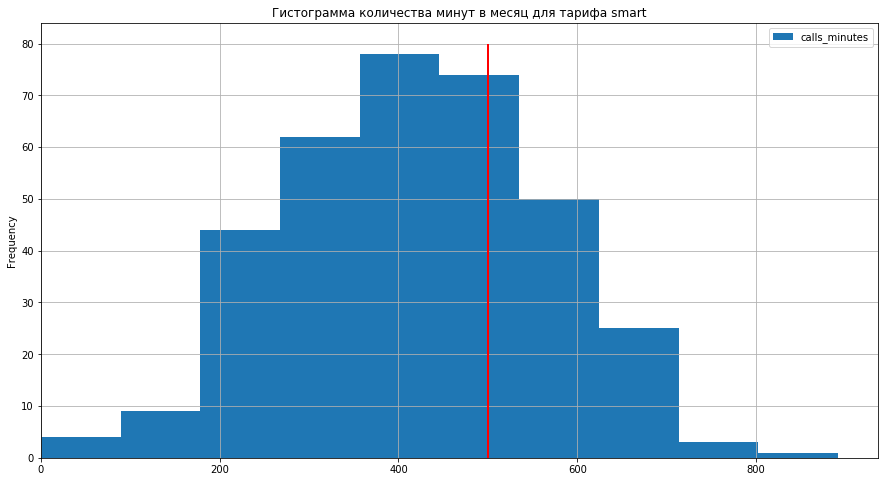

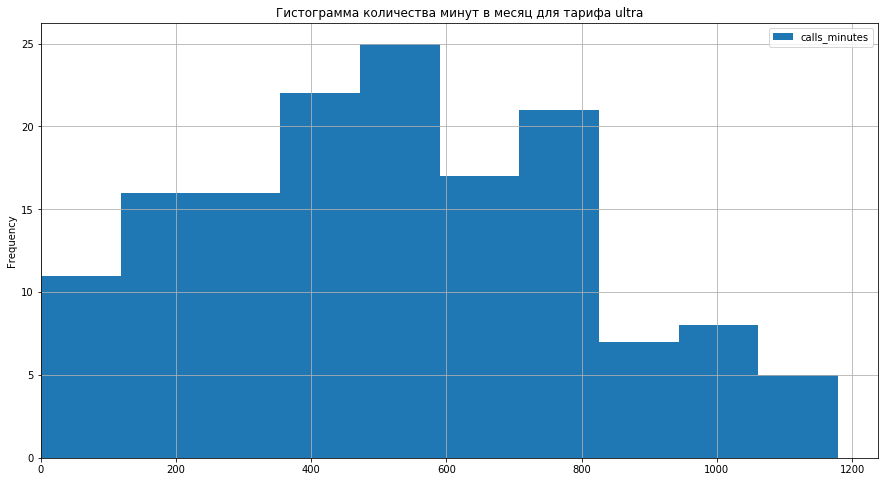

In [61]:
ax = smart['calls_minutes'].plot(kind='hist', bins=10, grid=True, legend=True, figsize=(15,8), xlim=0)
plt.title('Гистограмма количества минут в месяц для тарифа smart')
ax.vlines(500, 0, 80,
          color = 'r',
          linewidth = 2) # количество минут, включенное в тариф
plt.show()
ultra['calls_minutes'].plot(kind='hist', bins=10, grid=True, legend=True, figsize=(15,8), xlim=0)
plt.title('Гистограмма количества минут в месяц для тарифа ultra')
plt.show()

Построим диаграммы размаха.

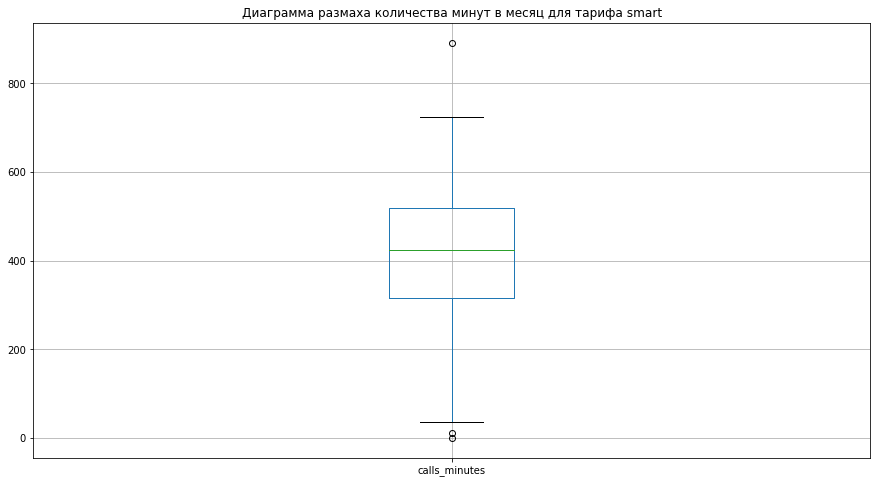

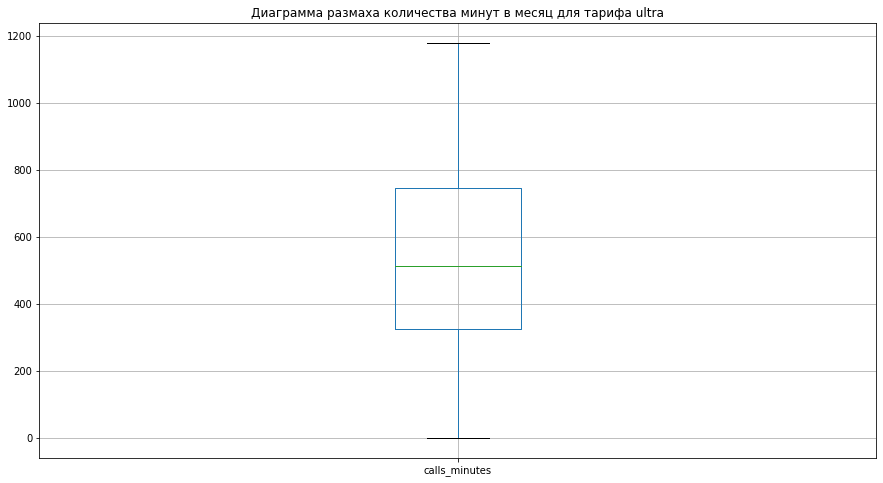

In [62]:
smart.boxplot(column='calls_minutes', figsize=(15,8))
plt.title('Диаграмма размаха количества минут в месяц для тарифа smart')
plt.show()
ultra.boxplot(column='calls_minutes', figsize=(15,8))
plt.title('Диаграмма размаха количества минут в месяц для тарифа ultra')
plt.show()

In [63]:
smart['calls_minutes'].describe()

count    350.000000
mean     419.634803
std      145.031543
min        0.000000
25%      316.886364
50%      425.062500
75%      519.508333
max      891.500000
Name: calls_minutes, dtype: float64

In [64]:
ultra['calls_minutes'].describe()

count     148.000000
mean      527.821819
std       281.786359
min         0.000000
25%       325.437500
50%       514.541667
75%       746.972222
max      1179.363636
Name: calls_minutes, dtype: float64

#### Вывод

Пользователи тарифа ultra в среднем используют большее количество минут разговора в месяц, чем пользователи тарифа smart: 528 и 420 минут соответственно. При этом каждый пользователь тарифа ultra в среднем в месяц не расходует и половины предоставляемых тарифным планом 3000 минут разговора: максимум 1180 минут. Для тарифа ultra в среднем расходуется 17,6%, а для тарифа smart - 84% предоставленных минут.

### Анализ количества сообщений в месяц

Посчитаем и сравним среднее, дисперсию и стандартное отклонение количества сообщений, которое требуется пользователям каждого тарифа в месяц.

In [65]:
smart_messages_mean = smart['messages_count'].mean()
smart_messages_var = np.var(smart['messages_count'], ddof=1)
smart_messages_std = np.std(smart['messages_count'], ddof=1)

ultra_messages_mean = ultra['messages_count'].mean()
ultra_messages_var = np.var(ultra['messages_count'], ddof=1)
ultra_messages_std = np.std(ultra['messages_count'], ddof=1)

messages_compare = [['mean', smart_messages_mean, ultra_messages_mean, smart_messages_mean-ultra_messages_mean],
                ['variance_estimate', smart_messages_var, ultra_messages_var, smart_messages_var-ultra_messages_var],
                ['standard_deviation', smart_messages_std, ultra_messages_std, smart_messages_std-ultra_messages_std]]
columns = ['comparative values','smart','ultra','difference']
messages_compare_table = pd.DataFrame(data = messages_compare, columns = columns)
messages_compare_table

,comparative values,smart,ultra,difference
0,mean,32.352078,54.030743,-21.678665
1,variance_estimate,702.909910,2149.828793,-1446.918884
2,standard_deviation,26.512448,46.366246,-19.853798


Построим гистограммы и диаграммы размаха для каждого тарифа.

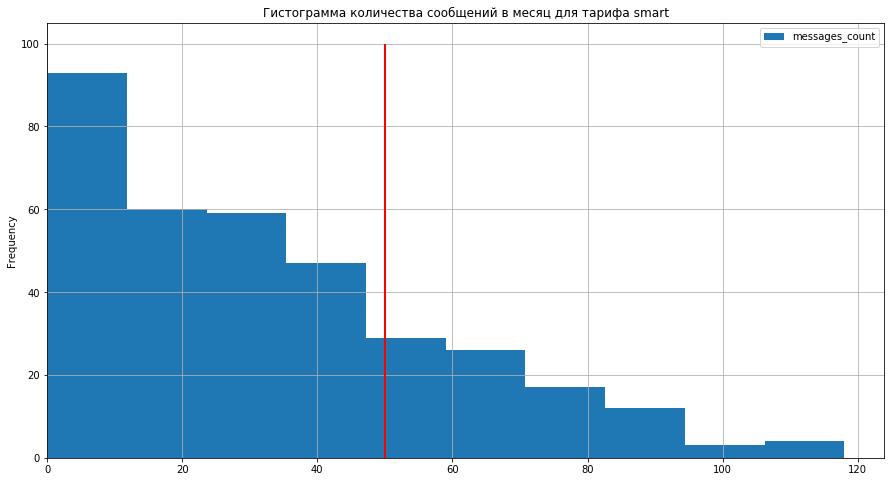

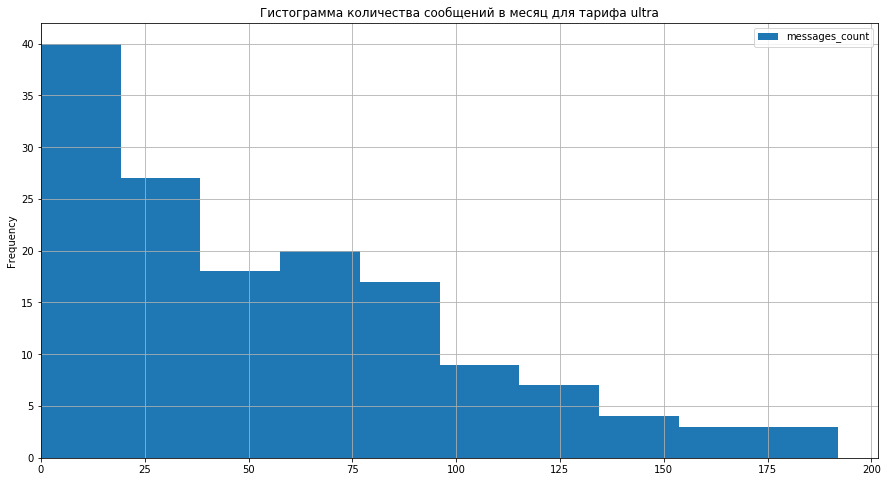

In [66]:
ax = smart['messages_count'].plot(kind='hist', bins=10, grid=True, legend=True, figsize=(15,8), xlim=0)
plt.title('Гистограмма количества сообщений в месяц для тарифа smart')
ax.vlines(50, 0, 100,
          color = 'r',
          linewidth = 2) # количество сообщений, включенное в тариф
plt.show()
ultra['messages_count'].plot(kind='hist', bins=10, grid=True, legend=True, figsize=(15,8), xlim=0)
plt.title('Гистограмма количества сообщений в месяц для тарифа ultra')
plt.show()

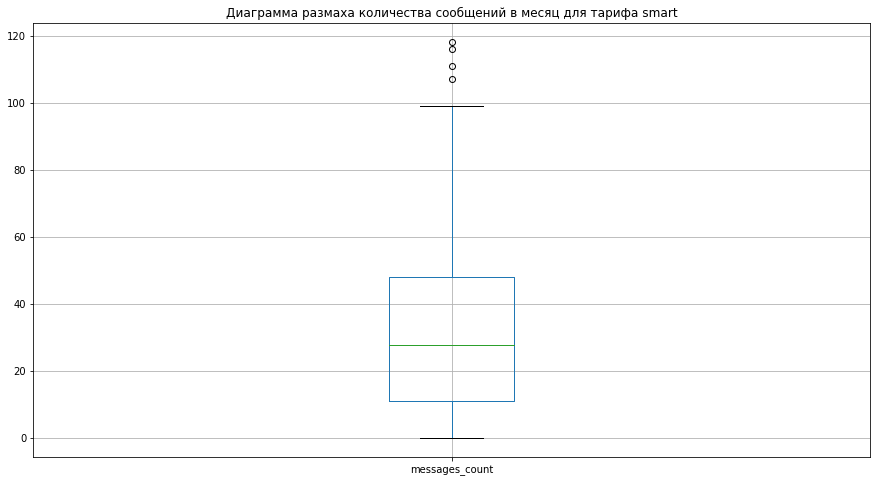

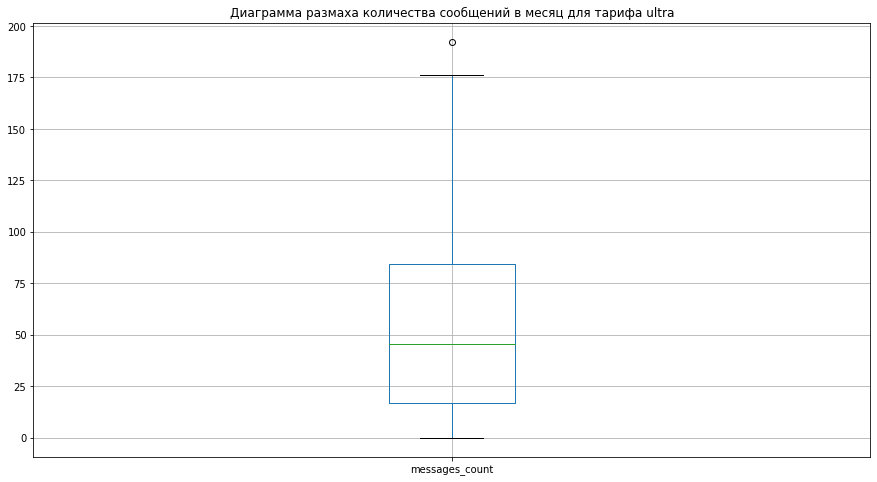

In [67]:
smart.boxplot(column='messages_count', figsize=(15,8))
plt.title('Диаграмма размаха количества сообщений в месяц для тарифа smart')
plt.show()
ultra.boxplot(column='messages_count', figsize=(15,8))
plt.title('Диаграмма размаха количества сообщений в месяц для тарифа ultra')
plt.show()

In [68]:
smart['messages_count'].describe()

count    350.000000
mean      32.352078
std       26.512448
min        0.000000
25%       11.000000
50%       27.750000
75%       48.000000
max      118.000000
Name: messages_count, dtype: float64

In [69]:
ultra['messages_count'].describe()

count    148.000000
mean      54.030743
std       46.366246
min        0.000000
25%       17.000000
50%       45.500000
75%       84.250000
max      192.000000
Name: messages_count, dtype: float64

#### Вывод

Наибольшее количество пользователей в обоих тарифах не используют сообщения. Распределения имеют пик на нуле и «длинный хвост» в положительную сторону (распределение Пуассона). В среднем пользователи тарифного плана smart отправляют 32 сообщения (64% тарифного плана), а пользователи тарифа ultra - 54 сообщения (5% тарифного плана).

### Анализ количества интернет-трафика в месяц

Посчитаем и сравним среднее, дисперсию и стандартное отклонение количества интеренет-трафика, которое требуется пользователям каждого тарифа в месяц.

In [70]:
smart_internet_mean = smart['mb_used'].mean()
smart_internet_var = np.var(smart['mb_used'], ddof=1)
smart_internet_std = np.std(smart['mb_used'], ddof=1)

ultra_internet_mean = ultra['mb_used'].mean()
ultra_internet_var = np.var(ultra['mb_used'], ddof=1)
ultra_internet_std = np.std(ultra['mb_used'], ddof=1)

internet_compare = [['mean', smart_internet_mean, ultra_internet_mean, smart_internet_mean-ultra_internet_mean],
                ['variance_estimate', smart_internet_var, ultra_internet_var, smart_internet_var-ultra_internet_var],
                ['standard_deviation', smart_internet_std, ultra_internet_std, smart_internet_std-ultra_internet_std]]
columns = ['comparative values','smart','ultra','difference']
internet_compare_table = pd.DataFrame(data = internet_compare, columns = columns)
internet_compare_table

,comparative values,smart,ultra,difference
0,mean,1.620139e+04,1.959284e+04,-3.391451e+03
1,variance_estimate,1.284248e+07,6.920167e+07,-5.635919e+07
2,standard_deviation,3.583641e+03,8.318754e+03,-4.735113e+03


Построим гистограммы и диаграммы размаха для каждого тарифа.

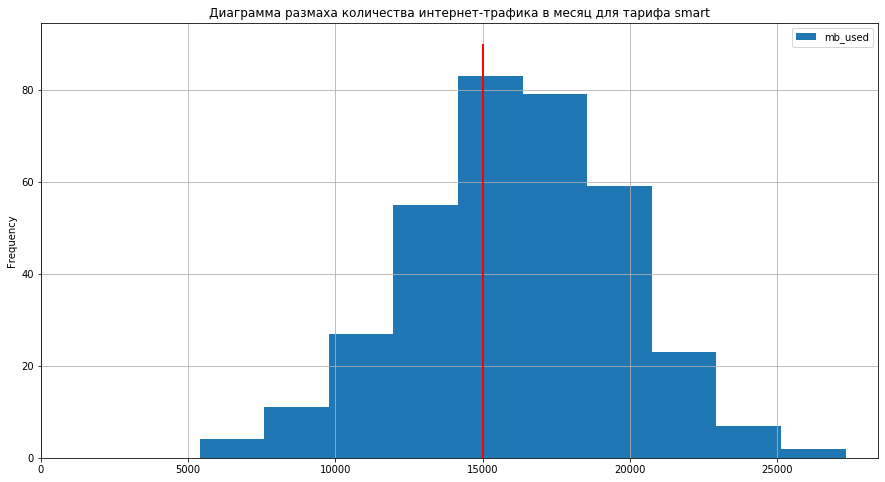

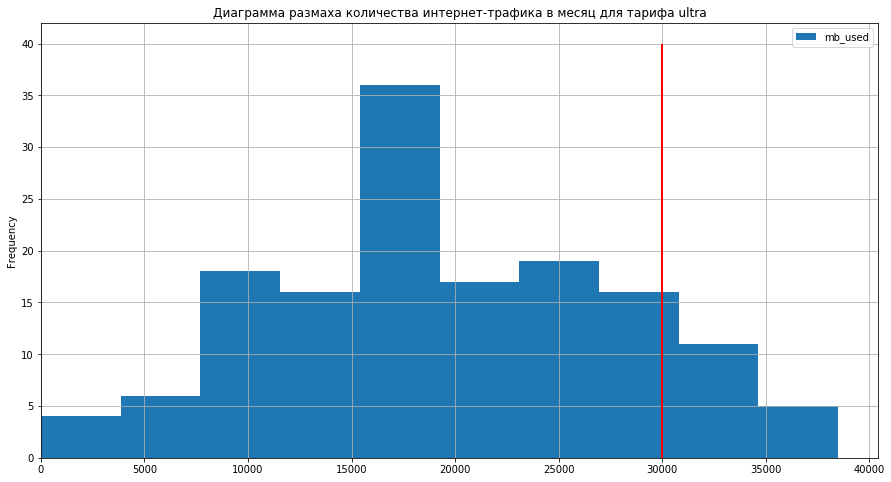

In [71]:
ax = smart['mb_used'].plot(kind='hist', bins=10, grid=True, legend=True, figsize=(15,8), xlim=0)
ax.vlines(15000, 0, 90,
          color = 'r',
          linewidth = 2) # количество интернет-трафика, включенное в тариф
plt.title('Диаграмма размаха количества интернет-трафика в месяц для тарифа smart')
plt.show()
ax = ultra['mb_used'].plot(kind='hist', bins=10, grid=True, legend=True, figsize=(15,8), xlim=0)
ax.vlines(30000, 0, 40,
          color = 'r',
          linewidth = 2) # количество интернет-трафика, включенное в тариф
plt.title('Диаграмма размаха количества интернет-трафика в месяц для тарифа ultra')
plt.show()

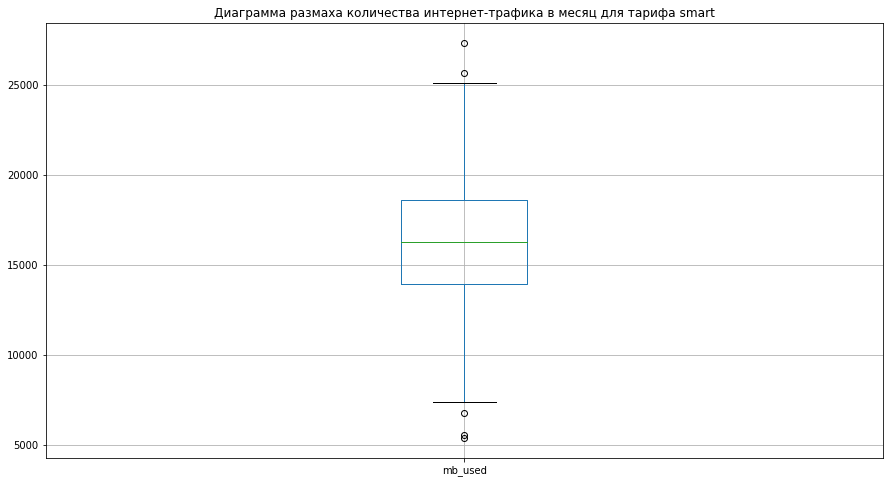

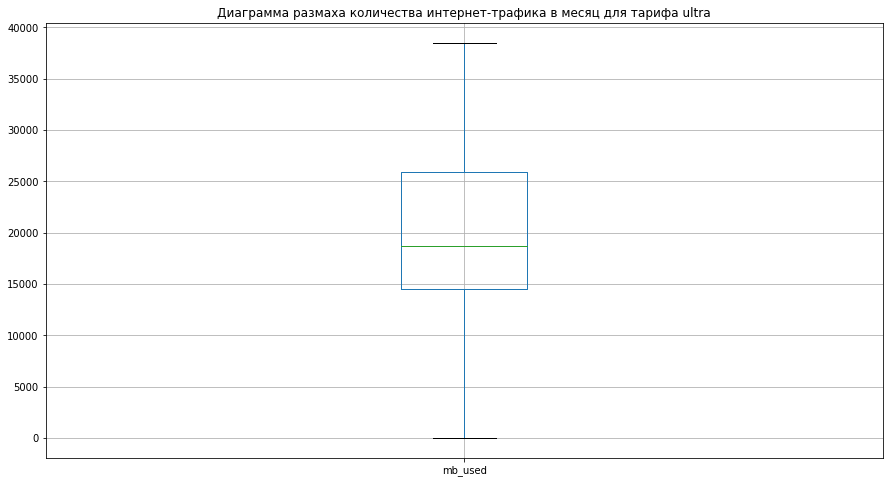

In [72]:
smart.boxplot(column='mb_used', figsize=(15,8))
plt.title('Диаграмма размаха количества интернет-трафика в месяц для тарифа smart')
plt.show()
ultra.boxplot(column='mb_used', figsize=(15,8))
plt.title('Диаграмма размаха количества интернет-трафика в месяц для тарифа ultra')
plt.show()

In [73]:
smart['mb_used'].describe()

count      350.000000
mean     16201.387920
std       3583.640810
min       5391.181818
25%      13934.035714
50%      16272.357143
75%      18620.263889
max      27321.000000
Name: mb_used, dtype: float64

In [74]:
ultra['mb_used'].describe()

count      148.000000
mean     19592.839001
std       8318.753942
min          0.000000
25%      14504.429545
50%      18715.550000
75%      25906.544643
max      38502.000000
Name: mb_used, dtype: float64

#### Вывод

В среднем использование интернет-трафика у пользователей тарифа ultra больше: 19593 МБ против 16201 МБ у пользователей тарифа smart. Это 65% и 108% соответственно. Т.е. больше 50% пользователей тарифа smart доплачивают за используемый сверх плана интернет-трафик.

## Шаг 4. Проверка гипотез

### Анализ выручки в месяц

Проведем анализ выручки пользователей каждого тарифа. Т.к. часть пользователей тарифа smart доплачивает за используемые сверх плана минуты, сообщения и интернет-трафик, а среди пользователей тарифа ultra доплачивают только менее 25% пользователей за используемый сверх плана интернет-трафик, а также стоимость минут, сообщений, интернет-трафика сверх тарифа для пользователей smart выше, предположим, что средняя выручка по пользователю тарифа smart выше, чем по пользователю тарифа ulta. 

Посчитаем и сравним среднее, дисперсию и стандартное отклонение выручки по пользователям каждого тарифа в месяц.

In [75]:
smart_total_pay_mean = smart['total_pay'].mean()
smart_total_pay_var = np.var(smart['total_pay'], ddof=1)
smart_total_pay_std = np.std(smart['total_pay'], ddof=1)

ultra_total_pay_mean = ultra['total_pay'].mean()
ultra_total_pay_var = np.var(ultra['total_pay'], ddof=1)
ultra_total_pay_std = np.std(ultra['total_pay'], ddof=1)

total_pay_compare = [['mean', smart_total_pay_mean, ultra_total_pay_mean, smart_total_pay_mean-ultra_total_pay_mean],
                ['variance_estimate', smart_internet_var, ultra_internet_var, smart_internet_var-ultra_internet_var],
                ['standard_deviation', smart_internet_std, ultra_internet_std, smart_internet_std-ultra_internet_std]]
columns = ['comparative values','smart','ultra','difference']
total_pay_compare_table = pd.DataFrame(data = total_pay_compare, columns = columns)
total_pay_compare_table

,comparative values,smart,ultra,difference
0,mean,1.280424e+03,2.079268e+03,-7.988442e+02
1,variance_estimate,1.284248e+07,6.920167e+07,-5.635919e+07
2,standard_deviation,3.583641e+03,8.318754e+03,-4.735113e+03


Построим гистограммы и диаграммы размаха для каждого тарифа.

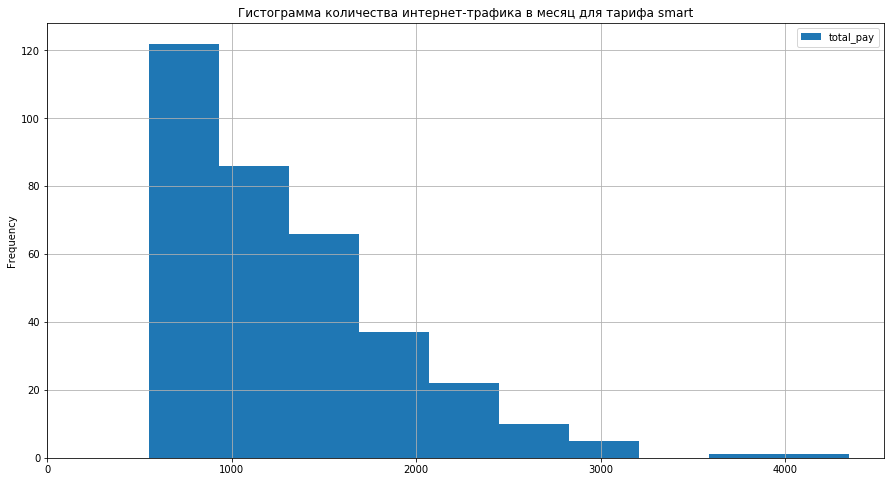

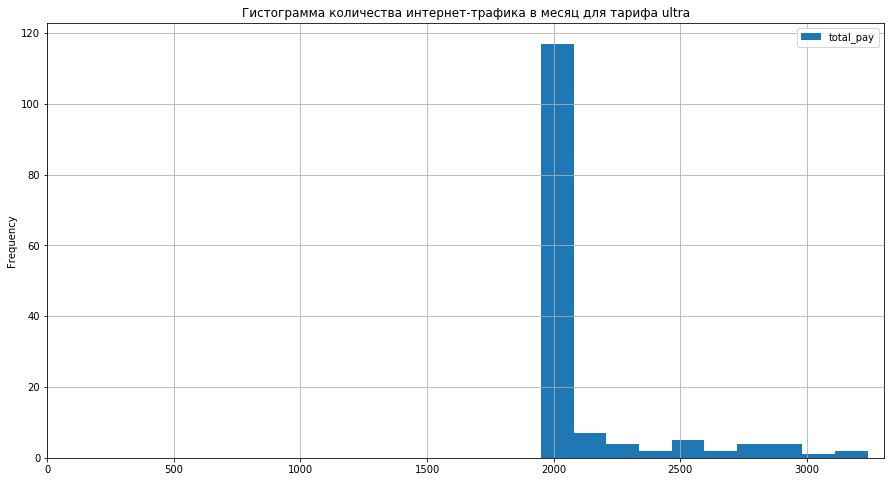

In [76]:
smart['total_pay'].plot(kind='hist', bins=10, grid=True, legend=True, figsize=(15,8), xlim=0)
plt.title('Гистограмма количества интернет-трафика в месяц для тарифа smart')
plt.show()
ultra['total_pay'].plot(kind='hist', bins=10, grid=True, legend=True, figsize=(15,8), xlim=0)
plt.title('Гистограмма количества интернет-трафика в месяц для тарифа ultra')
plt.show()

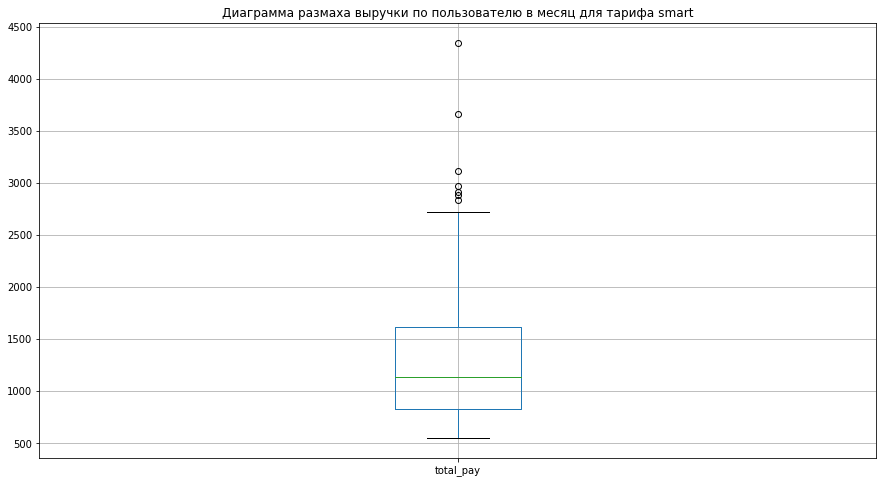

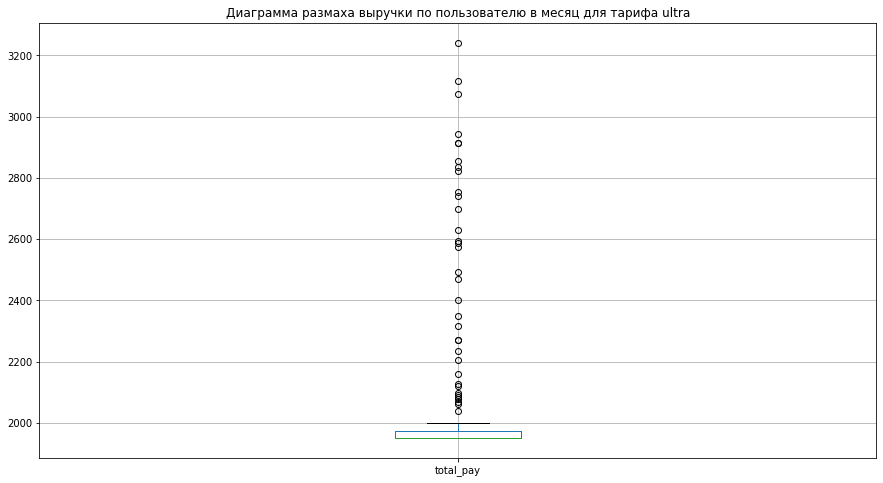

In [77]:
smart.boxplot(column='total_pay', figsize=(15,8))
plt.title('Диаграмма размаха выручки по пользователю в месяц для тарифа smart')
plt.show()
ultra.boxplot(column='total_pay', figsize=(15,8))
plt.title('Диаграмма размаха выручки по пользователю в месяц для тарифа ultra')
plt.show()

In [78]:
smart['total_pay'].describe()

count     350.000000
mean     1280.424109
std       599.306247
min       550.000000
25%       829.763636
50%      1133.950000
75%      1614.891667
max      4347.266667
Name: total_pay, dtype: float64

In [79]:
ultra['total_pay'].describe()

count     148.000000
mean     2079.268320
std       287.471675
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1974.231250
max      3241.125000
Name: total_pay, dtype: float64

#### Вывод

Предположение не подтвердилось: хотя пользователи тарифа smart и используют больше дополнительных минут, сообщений и интернет-трафика, но средняя выручка пользователя тарифа ultra больше: 2079 рублей против 1280 рублей для тарифа smart. Выручка почти 75% пользователей тарифа ultra не превышает ежемесячной платы за тариф в 1950 рублей, тогда как для 75% пользователей тарифа smart выручка не превышает этой суммы и составляет от 550 до 1615 рублей.

### Проверка гипотезы "средняя выручка пользователей тарифов «Ультра» и «Смарт» различается"

Для проверки данной гипотезы воспользуемся методом проверки гипотезы о равенстве средних двух генеральных совокупностей.  
Нулевую гипотезу сформулируем следующим образом:  
**H₀ - средняя выручка пользователей тарифа "Ультра" равна средней выручке пользователей тарифа "Смарт".**  
Альтернативная гипотеза будет звучать следующим образом:  
**H₁ - средняя выручка пользователей тарифа «Ультра» не равна средней выручке пользователей тарифа «Смарт».**  
Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применим метод scipy.stats.ttest_ind (array1, array2, equal_var).

Создадим выборку из 100 значений средних выручек в месяц для каждого тарифа.

In [80]:
smart_array = smart.sample(n=100)['total_pay'].tolist()
ultra_array = ultra.sample(n=100)['total_pay'].tolist()

Применим общепринятое пороговое значение — 5%: если p-value меньше него, то отвергнем нулевую гипотезу.

In [81]:
alpha = .05

results = st.ttest_ind(
    smart_array, 
    ultra_array,
    equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.918793312902541e-25
Отвергаем нулевую гипотезу


#### Вывод

Значение p-value очень мало: меньше 1%, т.о. нулевая гипотеза отвергнута - средние выручки тарифов smart и ultra не равны.

### Проверка гипотезы "средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов"

Для проверки данной гипотезы воспользуемся методом проверки гипотезы о равенстве средних двух генеральных совокупностей.  
Нулевую гипотезу сформулируем следующим образом:  
**H₀ - средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.**  
Альтернативная гипотеза будет звучать следующим образом:  
**H₁ - средняя выручка пользователей из Москвы не равна средней выручке пользователей из других регионов.**  
Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применим метод scipy.stats.ttest_ind (array1, array2, equal_var).

Создадим выборки по 50 значений средний выручки для пользователей из Москвы и для пользователей из других регионов.

In [82]:
moscow_array = df.query('city == "Москва"').groupby('user_id')['total_pay'].agg('mean').reset_index().sample(n=50)['total_pay'].tolist()
region_array = df.query('city != "Москва"').groupby('user_id')['total_pay'].agg('mean').reset_index().sample(n=50)['total_pay'].tolist()

Применим общепринятое пороговое значение — 5%: если p-value меньше него, то отвергнем нулевую гипотезу.

In [83]:
alpha = .05

results = st.ttest_ind(
    moscow_array, 
    region_array)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.8646556733396799
Не получилось отвергнуть нулевую гипотезу


#### Вывод

Полученное значение p-value говорит о том, что хотя средняя выручка пользователей из Москвы и пользователей из других регионов и неодинаковое, с вероятностью 38% такое или большее различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними выручками этих пользователей.

## Шаг 5. Общий вывод

Пользователи тарифов smart и ultra используют услуги связи по-разному: в среднем пользователь тарифа  ultra расходует большее количество минут разговора (разница - 108 минут), сообщений ( разница - 22 сообщения) и интернет-трафика (разница - 3391 МБ) в месяц.

Для тарифа ultra в среднем расходуется 17,6%, а для тарифа smart - 84% предоставленных минут.

Наибольшее количество пользователей в обоих тарифах не используют сообщения. В среднем пользователи тарифа smart расходуют 64% сообщений, предоставляемых тарифным планом, а пользователи тарифа ultra - только 5%.

В среднем использование интернет-трафика у пользователей тарифа smart 108%, а у пользователей тарифа ultra - 65%. Больше 50% пользователей тарифа smart доплачивают за используемый сверх плана интернет-трафик.

Хотя пользователи тарифа smart и используют больше дополнительных минут, сообщений и интернет-трафика, но средняя выручка пользователя тарифа ultra больше: 2079 рублей против 1280 рублей для тарифа smart. Выручка почти 75% пользователей тарифа ultra не превышает ежемесячной платы за тариф в 1950 рублей, тогда как для 75% пользователей тарифа smart выручка не превышает этой суммы и составляет от 550 до 1615 рублей.

Результаты проверки гипотез: средние выручки тарифов smart и ultra не равны; средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов. 

Можно сделать вывод, что тарифный план ultra приносит больше денег: средняя выручка больше, чем у тарифа smart, и при этом остается много неиспользованных ресурсов (минут, сообщений и интернет-трафика, включенных в тариф). Привлечение большего количества клиентов на тариф ultra, принесет больше прибыли компании «Мегалайн».